# Experimental Cosmology

In this notebook, we will gain a taste of what it is like to work in an experimental cosmology lab setting. Of course, working remotely renders this exercise a rough approximation of the truth; however, there is still quite a lot we can do! 

As you will see in the other notebooks, working in Python is integral to cosmological analysis. But it also plays a major role in lab: we take a lot of intermediate data, from validating hardware, to recording the temperatures inside our cryostat over time. And being able to work with that data is just as important to achieving our ultimate science goals as the final scientific analysis coming from the telescope. 

You'll mainly be *applying* your knowledge of Python here; the aim of this notebook is to give you a sense of what a laboratory-based Python analysis might look like, since some of you will be working on more "experimental" projects this summer!

# Characterizing Detectors

The Cosmic Microwave Microwave (CMB) background is cold (you will learn why if you don't already know!). Like, really cold: its blackbody temperature is only ~2.7 K above absolute zero. And the anisotropies in the CMB are ~ 4 orders of magnitude smaller: about 100 uK! Cold things are dim of course, and so Simons Observatory (and any CMB observatory) must be capable of measuring changes on the order of 1/10,000th of a really dim thing.

To do this, we employ "Transition Edge Sensing" bolometers, or TES sensors, for short. Unlike the technology you'll find in an optical camera sensor, TESs are *extremely* sensitive to what we would ordinarily consider to be "small" amounts of radiation. You'll learn more about our detectors and the details of how they work during the crash course lectures, but here we consider a particular experiment we like to run on them: an optical efficiency measurement. 

We'll work up to the final analysis, but a lot of the code will be filled in by you! And there are *no right answers* -- you should do what you feel makes the most sense, or that you feel comfortable coding. As always, if you need any help, from specific questions to ideas, reach out to the #help_desk channel on the slack!

In order to perform this measurement, we use what's called a "cold load." A cold load is basically a blackbody *at microwave wavelengths* that fits into our cryostat and sits next to our detectors when we test them. If you want to learn more about them, check out [this paper](https://arxiv.org/pdf/1711.04841.pdf) from one of our predecessor experiments, ACT. Most of the authors are now SO scientists!

The cold load is reasonably large compared to the detector "beam" (the solid angle of the sphere that a detector is sensitive to, kind of like the direction a camera lens points), and sits pretty close to the detectors too, so we can assume here that our detectors can *only* see the cold load in this lab setup:

<img src = cl_cartoon.png>

The blue box represents the outer bounds of the cryostat. The black box is the cold load, and it is emitting high-frequency microwave radiation toward the detector. The detector, in gold, points at the cold load, and the solid angle it is sensitive to -- represented by the light blue cone -- is fully filled by the cold load.

We'll start by modeling the cold load, then we'll work up to modeling the power incident on the detector, and finally we'll perform the full measurement.

Before we get started, let's get our Google drive available in Colab:

In [ ]:
# Authenticate with your gmail account
# Run this cell, click on the link, authenticate with your gmail account,
# copy the link provided after authentication and paste it below
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your notebook/data directory
path = './'

And import necessary modules:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad as integrate
from scipy.constants import c, h, k

# Speed of light (SI units)
print(c)

# Planck constant (SI units)
print(h)

# Boltzmann constant (SI units)
print(k)

299792458.0
6.62607015e-34
1.380649e-23


# Modeling a Blackbody

The cold load emits perfect blackbody radiation at whatever temperature we set it to, usually somewhere between 5 K and 25 K. We should probably write a function that spits out the [Planck radiation formula](https://en.wikipedia.org/wiki/Black-body_radiation#Planck's_law_of_black-body_radiation): $$B(\nu, T) = \frac{2h\nu^3}{c^2}\frac{1}{e^\left(\frac{h\nu}{kT}\right) - 1}$$

In [8]:
# The spectral radiance of a blackbody at a frequency v and temperature T
def B(v, T):
    # your code here
    

In [2]:
def B(v, T):
    return 2*h*v**3/c*2/(np.exp(h*v/k/T) - 1)

where $h$ is Planck's constant, $c$ is the speed of light, and $k$ is the Boltzmann's constant. The units of this equation are fairly important: the power per unit area per unit solid angle per unit frequency emitted by the blackbody. 

Our detectors are optimized to work in frequency ranges from ~30 GHz to ~300 GHz. In fact, we have three "flavors" of detector, one for each frequency range. "LF" detectors are optimized for ~30 GHz. "MF" detectors are optimized for ~100 GHz. And "UHF" detectors (the "U" is for "ultra") are optimized for ~300 GHz. Let's plot what the blackbody spectrum emitted by our cold load looks like at a few different temperatures, as a function of frequency:

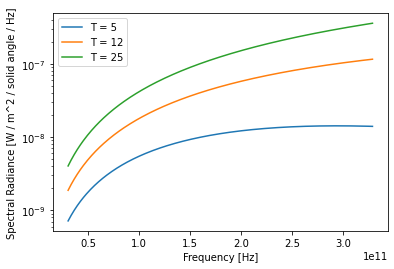

In [6]:
# Make a plot of B(v, T) at each T 
T = [5, 12, 25]

# The plot should be a function of frequency
# Units are Hertz, hence the "e9", which is the Python way of writing scientific notation
v = np.arange(30e9, 330e9, 1e9)

# Fill a multi-dimenstional with the spectral radiance B(v, T)
# at each T across all frequencies v
# The first axis should have size equal to the number of temperatures
# The second axis should have a size equal to the number of frequencies

# your code here - fill it in!
spectra = np.zeros(...)

# Add in the correct code instead of the dashes
for i in range(len(T)):
    spectra[i] = --------
    
# Plot your results
for i in range(len(T)):
    plt.plot(v, spectra[i], label = f'T = {T[i]}')

# Clean up the figure
plt.xlabel("Frequency [Hz]")
plt.ylabel("Spectral Radiance [W / m^2 / solid angle / Hz]")
plt.yscale("log")
plt.legend()
plt.show()

We briefly saw how to make a plot with multiple series of data in the last notebook; the key comes from adding the argument "label = *string*" to the plt.plot function. Then, we must add the function (which takes no arguments) plt.legend() later on. This makes the little color-coded box in the upper left!

This graph shows the spectral radiance emitted by the cold load as a function of frequency at several temperatures! Notice how when the cold load warms from 5 K to 25 K, the emount of power it emits via radiation goes up by *a lot*. 

# Calculating Incident Power

The end goal of this experimentis to measure optical *power* with the detectors, and compare that to what we expect. Because the units of the spectral radiance are power *per area per solid angle per frequency*, in principle we will have to integrate over 3 separate variables to just get power out in the end. Fortunately, two of these integrals -- over solid angle and area -- are easy. Let's throw them in now.

The "area" we integrate over is the area of the detector. It turns out this is given by a handy equation: $$A = \lambda^2 / \Omega_b$$ where $\lambda$ is the wavelength and $\Omega$ is the total solid angle of the beam -- how many "square degrees" on the sphere the "blue cone" coming out of the detector takes up. It's convenient to substitute $c^2/ \nu^2$ for $\lambda$.

The "solid angle" we integrate over is from the point of view of the detector. If a particular direction (again from the point of view of the detector) is not occupied by the cold load, then there is no radiation incident on the detector from that direction, so that direction *does not contribute to the integral*. The net effect is that integrating the spectral radiance over solid angle essentially reduces to multiplying by the solid angle occupied by the cold load -- $\Omega_{cl}$ -- from the point of view of the detector. Putting it all together: $$S(\nu, T) = \frac{\Omega_{cl}}{\Omega_b}\frac{2h\nu}{e^\left(\frac{h\nu}{kT}\right) - 1}$$ where $S$ is now just the power *per unit frequency*.

Let's figure out what the ratio of $\Omega$ terms in the front is. I glossed over a subtle point when I defined each $\Omega$: really these are *beam-weighted* solid-angles, which captures the notion that the detectors are more sensitive in the "middle" of the beam than at the edge. The effect is that the ratio of $\Omega$ terms is really just the *fraction* of the beam occupied by the cold load. Earlier we assumed that the cold load is large enough and close enough to the detector that it fills its field-of-view, so this fraction is just 1!

Just one last point: our detectors are sensitive to only *one* of the two linear polarizations of the incoming photons, meaning we just have to tack on an extra factor of 0.5. So finally: $$S(\nu, T) = \frac{h\nu}{e^\left(\frac{h\nu}{kT}\right) - 1}$$ where $S$ is the power *per unit frequency* entering the detector.

In [35]:
# Define a new function S that gives the power per unit frequency entering the detector
def S(v, T):
    # your code here
    return h*v/(np.exp(h*v/k/T) - 1)

In practice, we place filters in between the cold load and detector *and* inside the detector itself which help define a "bandpass". A "bandpass" basically means that radiation only at particular frequencies makes it all the way to the detector -- the rest is blocked. The bandpass has a lower edge and an upper edge: below the lower edge and above the upper edge, no radiation gets through. In between, all the radiation gets through. Here's some quick food for thought: the filter that goes between the cold load and detector defines the upper edge, while the filter inside the detector itself defines the lower edge: what physics could be at work that might explain this? 

Let's call the bandpass $f(\nu)$. Then finally we can write down what the total power incident on the detector is: $$P(T) = \int{S(\nu, T) * f(\nu) d\nu}$$
where $T$ is the "blackbody temperature" of the radiation -- in other words, the different multicolored curves we plotted earlier!

In [28]:
# Time to code!

# Consider our "MF" detectors, which are sensitive near ~ 100 GHz frequencies

# Let's say the bandpass for the MF detectors has a low edge of 80 GHz and
# an upper edge of 120 GHz

def f(v):
    
    # Define band edges
    low = 80e9
    high = 120e9
    
    if v > low and v < high: return 1
    else: return 0
# Plot this bandpass over a range of frequenies
# We'll give you the array of frequencies, it's the same as before
v = v = np.arange(30e9, 330e9, 1e9)

# your code to plot goes here

# feel free to make the plot as fancy as you'd like! Add labels, add a title, etc.

Awesome! Now let's apply our bandpass to the power per frequency incident on the detector, $S$, for a range of cold load temperatures:

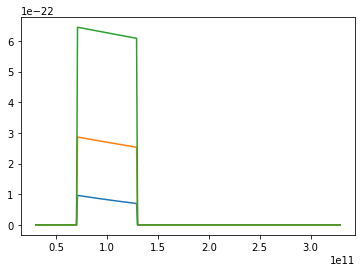

In [14]:
# Pick your range of temperatures, and put them in a list
# You can use the list "T" from earlier or experiment with your own!

# T = --------

# Plot the product of S and f over the frequency range, for each temperature

# your code here

# Each curve should look like a "tophat" -- 0 outside the band and non-zero inside

The integrals of these curves over the x-axis (frequency) will be the total power incident into the detector at *that specific cold load temperature*.

# Measuring Optical Efficiency

Now that we have the tools in place, let's perform the experiment! If we were all in lab together, we might be able to *actually* do this, but for now, we'll use some mock data.

The experiment setup is to heat the cold load to some fixed temperature $T$, usually between 5 K and 25 K, and measure how much power the detector is absorbing. Usually, the detector measures a little bit less power than actually hits it, because it isn't perfectly efficient. We want to know *how* efficient it actually is.

This will entail comparing our measured power (as a function of temperature) to our predicted power (as a function of temperature). Let's first determine what the predicted power is. This requires that we *integrate* the "tophat" curves that you just plotted! To facilitate this, we imported the *scipy.integrate.quad* function under the name "integrate" in the beginning of the notebook. Here's the [link to the API](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) if you're curious how this function works in deep detail.

For our purposes, let's walk through what we need to make our "integrate" function work. There are four arguments we will need to pass to call to "integrate":

* A function to integrate. This function must take as its arguments the variable to be integrate over *first*, followed by any other arguments that help define the function.
* The lower limit of integration
* The upper limit of integration
* The "other arguments" that help define the function to be integrated.

Let's look at an example of how to use the "integrate" function; then, you will use it in the case of our optical power calculations! 

In [65]:
# Let's integrate the function f(x) = Ax^3 from 0 to 1
# We expect an answer of A/4

# First, define our function to be integrated
# The first argument must be the variable that is integrated over, followed 
# by A, which will fully define the function to be integrated

def trial_function(x, A):
    return A * x**3

# Let's try it for A = 3, so we expect 0.75
answer, error = integrate(trial_function, 0, 1, args = (3))
print(answer, error)

0.75 8.326672684688674e-15


Let's breakdown what happened here. We want to integrate over $x$, so that must be the first variable in our trial function. The prefactor $A$ is the second argument. Put together, the trial function is *itself* the *first* argument to pass into the "integrate" function. Then comes the lower bound (0), the upper bound (1), and then this interesting "args" argument. "args" must be a *tuple* of the "extra arguments" that "trial_function" needs in order to work properly -- in this case, the prefactor $A$. A *tuple* is a sibling of a list, except it uses parantheses instead of brackets.

The function "integrate" has two outputs: the value of the integral, and an *estimate* of the error in that value. We must provide *two* variable to hold these outputs. It turns out "integrate" does exceptionally well here! It gets the right answer, and the error in that answer is effectively nothing.

Now you get to apply this knowledge to our experiment:

In [ ]:
# Define the function that we pass to "integrate" as its first argument

# Remember, we are integrating over frequency, so that must be the *first* argument
# of our function to be integrated
def integrate_this(v, T):
    
    # this should be the "tophat" function from earlier
    # your code here
    
# We want the power incident upon one of our MF detectors as a function of
# cold load temperature
# Please use the below array of temperatures
T = np.arange(5, 26)

# Prepare an output array which will hold our predicted incident power
predicted_power = np.zeros(len(T))

# Set the low and high bounds of the integral
low = 50e9 # below the lower edge of the tophat
high = 150e9 # above the upper edge of the top hat

# Loop over the temperatures and fill the output array
# with the predicted power
# Hint: neglect the error! It will look large. If you're curious, try 
# to figure out what the "actual" value of the integral is -- why does
# "integrate" think it performs worse than it actually does?

# Remember, we are integrating over frequencies for each fixed temperature

# your code here

# Plot the output array as a function of temperature

# your code here

Great job! Notice how small the power incident on the detector is -- of order picowatts! To put that in perspective, if you tried lifting a 1kg object with 1pW of power, it would take you more than 300,000 years to raise it by 1 meter. 

Now let's load the measured data:

In [68]:
# Load the data
data = np.loadtxt(path + 'optical_powers.txt')

# The first column holds the temperatures
T_meas = -------

# The second column holds the measured power
measured_power = ------

# On the same plot, show the predicted power and measured power as a function of temperature

# your code here

SyntaxError: invalid syntax (<ipython-input-68-aa90e8c82ba2>, line 5)

Notice how at every temperature, the measured power is a *little* less than predicted. Now comes the most fun part -- the analysis. Unlike in class, in experimental work, there is rarely as "right" answer. This is great because you get to do what *you* want, so long as you can justify it. We want to report the optical efficiency of this detector as a single number, a percentage. *You* get to decide how you come up with this number, based on your "predicted_power" and "measured_power" arrays.

Have at it!

In [ ]:
# your code here